In [15]:
import csv, sys, pickle, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

### Data Parsing, Processing, Feature Making

In [2]:
# Get data
with open('./data_split.pkl') as f:
    TRAINDATA, VALDATA, TESTDATA = pickle.load(f)
print TRAINDATA[0].keys()

['', 'cut', 'color', 'clarity', 'price', 'carat', 'depth', 'table', 'y', 'x', 'z']


In [3]:
# PREPROCESS: define averages and onehots
AVERAGES = [0.0]*6 # [carat,depth,table,x,y,z]
for d in TRAINDATA:
    AVERAGES[0] += float(d['carat'])
    AVERAGES[1] += float(d['depth'])
    AVERAGES[2] += float(d['table'])
    AVERAGES[3] += float(d['x'])
    AVERAGES[4] += float(d['y'])
    AVERAGES[5] += float(d['z'])
AVERAGES = [c/len(TRAINDATA) for c in AVERAGES]

# TO ONE HOT.
#  1. one hot for cut [0:Fair, 1:Good, 2:Very Good, 3:Premium, 4:Ideal]
#  2. one hot color [0:J, 1:I, 2:H, 3:G, 4:F, 5:E, 6:D]
#  3. one hot clarity [0:I1,1:SI2,2:SI1,3:VS2,4:VS1,5:VVS2,6:VVS1,7:IF]
cut2idx = {'Fair': 0,'Good': 1,'Very Good': 2,'Premium': 3,'Ideal': 4 }
color2idx = {'J': 0,'I': 1,'H': 2,'G': 3,'F': 4,'E': 5,'D': 6 }
clarity2idx = {'I1': 0,'SI2': 1,'SI1': 2,'VS2': 3,'VS1': 4,'VVS2': 5,'VVS1': 6, 'IF': 7}
def toOneHot(exDict):
    cut,col,cla = [0.0]*5, [0.0]*7, [0.0]*8
    cut[cut2idx[exDict['cut']]] = 1.0
    col[color2idx[exDict['color']]] = 1.0
    cla[clarity2idx[exDict['clarity']]] = 1.0
    return cut,col,cla

# [label | cut | color | clarity || carat | depth | table | x | y | z]
def createFeature(listDicts):
    feats = []
    for i in range(len(listDicts)):
        lab = [float(listDicts[i]['price'])]
        cut,col,cla = toOneHot(listDicts[i])
        tmp = []
        tmp.append(float(listDicts[i]['carat']) - AVERAGES[0])
        tmp.append(float(listDicts[i]['depth']) - AVERAGES[1])
        tmp.append(float(listDicts[i]['table']) - AVERAGES[2])
        tmp.append(float(listDicts[i]['x']) - AVERAGES[3])
        tmp.append(float(listDicts[i]['y']) - AVERAGES[4])
        tmp.append(float(listDicts[i]['z']) - AVERAGES[5])
        feats.append(lab + cut + col + cla + tmp)
    return feats

trainFeat = np.array(createFeature(TRAINDATA))
valFeat = np.array(createFeature(VALDATA))
testFeat = np.array(createFeature(TESTDATA))

### Network Definitions

In [4]:
### Parameters
NUM_FEAT = len(trainFeat[0]) - 1
LAYER_WIDTHS = [NUM_FEAT,100,100,1] #[# features, # layer1 nodes, # layer2 nodes ... ]

NUM_EPOCHS = 1000
BATCH_SIZE = 100
LR = 0.001

In [5]:
### Network architecture
class Net(nn.Module):
    def __init__(self,layerDefs):
        self.layerDefs = layerDefs
        super(Net,self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.FC1 = nn.Linear(self.layerDefs[0],self.layerDefs[1])
        self.FC2 = nn.Linear(self.layerDefs[1],self.layerDefs[2])
        self.FC3 = nn.Linear(self.layerDefs[2],self.layerDefs[3])
        
    def forward(self,x):
        x = self.sigmoid(self.FC1(x))
        x = self.sigmoid(self.FC2(x))
        x = self.FC3(x)
        return x

### Train

In [6]:
### Helper Functions
def saveModel(net):
    # save model
    print '\nSaving Model..'
    torch.save(net, './catOnlyModel.pt')
    print 'Done saving model..'
def testVal(net):
    print 'Testing accuracy on validation set..'
    toterror = 0.0
    totloss = 0.0
    numBatches = 0
    
    idxList = range(len(valFeat))
    while(len(idxList)>0):
        batchIdxs = []
        for idxz in range(BATCH_SIZE):
            if len(idxList) == 0:
                break
            batchIdxs.append(idxList.pop())
        
        batch_data = valFeat[batchIdxs]
        batch_F = batch_data[:,1:]
        batch_L = batch_data[:,0]
    
        inData = torch.from_numpy(batch_F)
        inData = inData.float()
        inData = Variable(inData.cuda())
        
        label = torch.from_numpy(batch_L)
        label = label.float()
        label = Variable(label.cuda(),requires_grad=False)
        
        # forward pass
        outData = net(inData)
        loss = criterion(outData,label)
        totloss += loss.data[0]
        
        # get error
        outData = outData.cpu().data.numpy()
        label = label.cpu().data.numpy()
        toterror += np.sum((outData - label) ** 2)
        
        numBatches += 1
                
    return totloss/numBatches, toterror/len(valFeat)


### Define Net and Train
net = Net(LAYER_WIDTHS)
net = net.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

trainLoss = []
valLoss, valError = [], []
for epoch in range(NUM_EPOCHS):
    
    print '\n=========================='
    print 'Starting Epoch {}'.format(epoch+1)
    print '=========================='
    
    vl,ve = testVal(net)
    print 'Validation loss: %.4f'% (vl)
    print 'Validation error: %.4f' % (ve)
    valLoss.append(vl)
    valError.append(ve)
    
    idxList = range(len(trainFeat))
    random.shuffle(idxList)
    
    iterCount = 0
    while(len(idxList)>0):
        
        batchIdxs = []
        for idxz in range(BATCH_SIZE):
            if len(idxList) == 0:
                break
            batchIdxs.append(idxList.pop())
        
        batch_data = trainFeat[batchIdxs]
        batch_F = batch_data[:,1:]
        batch_L = batch_data[:,0]
    
        inData = torch.from_numpy(batch_F)
        inData = inData.float()
        inData = Variable(inData.cuda())

        label = torch.from_numpy(batch_L)
        label = label.float()
        label = Variable(label.cuda(),requires_grad=False)

        # train
        optimizer.zero_grad()
        outData = net(inData)
        loss = criterion(outData,label)
        loss.backward()
        optimizer.step()

        # print and recordstats
        trainLoss.append(loss.data[0])
        '''
        if (iterCount % int(len(trainFeat)/BATCH_SIZE)/3 == 0):
            print('[Epoch:%d, Batch:%5d] loss: %.4f' %
                  (epoch + 1, iterCount + 1, trainLoss[-1]))
        '''
        iterCount += 1
        
saveModel(net)



Starting Epoch 1
Testing accuracy on validation set..
Validation error: 30598292.0648
Validation loss: 3055136450.5866

Starting Epoch 2
Testing accuracy on validation set..
Validation error: 30364961.2222
Validation loss: 3031854971.8710

Starting Epoch 3
Testing accuracy on validation set..
Validation error: 30123357.2037
Validation loss: 3007710749.8050

Starting Epoch 4
Testing accuracy on validation set..
Validation error: 29854754.5093
Validation loss: 2980882526.9203

Starting Epoch 5
Testing accuracy on validation set..
Validation error: 29594822.4259
Validation loss: 2954921187.4290

Starting Epoch 6
Testing accuracy on validation set..
Validation error: 29344922.2130
Validation loss: 2929961206.7927

Starting Epoch 7
Testing accuracy on validation set..
Validation error: 29092258.9167
Validation loss: 2904726968.8098

Starting Epoch 8
Testing accuracy on validation set..
Validation error: 28849865.6204
Validation loss: 2880518342.1935

Starting Epoch 9
Testing accuracy on va


Starting Epoch 48
Testing accuracy on validation set..
Validation error: 21012437.0000
Validation loss: 2247169801.9666

Starting Epoch 49
Testing accuracy on validation set..
Validation error: 20846714.7407
Validation loss: 2237982388.1587

Starting Epoch 50
Testing accuracy on validation set..
Validation error: 20682117.0741
Validation loss: 2231338787.0256

Starting Epoch 51
Testing accuracy on validation set..
Validation error: 20518829.3194
Validation loss: 2220517047.1961

Starting Epoch 52
Testing accuracy on validation set..
Validation error: 20356922.9028
Validation loss: 2208461039.1991

Starting Epoch 53
Testing accuracy on validation set..
Validation error: 20196123.1204
Validation loss: 2201413401.9132

Starting Epoch 54
Testing accuracy on validation set..
Validation error: 20037008.5046
Validation loss: 2194586795.2362

Starting Epoch 55
Testing accuracy on validation set..
Validation error: 19878737.9491
Validation loss: 2187171063.9318

Starting Epoch 56
Testing accur


Starting Epoch 95
Testing accuracy on validation set..
Validation error: 14431543.6944
Validation loss: 1981339537.1331

Starting Epoch 96
Testing accuracy on validation set..
Validation error: 14315280.8056
Validation loss: 1978860768.3915

Starting Epoch 97
Testing accuracy on validation set..
Validation error: 14199768.3935
Validation loss: 1974720765.6270

Starting Epoch 98
Testing accuracy on validation set..
Validation error: 14085022.9167
Validation loss: 1975655201.8865

Starting Epoch 99
Testing accuracy on validation set..
Validation error: 13971635.5787
Validation loss: 1969800296.4123

Starting Epoch 100
Testing accuracy on validation set..
Validation error: 13858649.3032
Validation loss: 1969362296.2640

Starting Epoch 101
Testing accuracy on validation set..
Validation error: 13746734.2222
Validation loss: 1965469057.3763

Starting Epoch 102
Testing accuracy on validation set..
Validation error: 13635801.4213
Validation loss: 1962727840.8899

Starting Epoch 103
Testing a


Starting Epoch 142
Testing accuracy on validation set..
Validation error: 9836419.7986
Validation loss: 1955992337.1806

Starting Epoch 143
Testing accuracy on validation set..
Validation error: 9756321.6852
Validation loss: 1954938170.7557

Starting Epoch 144
Testing accuracy on validation set..
Validation error: 9676228.7662
Validation loss: 1955701466.5065

Starting Epoch 145
Testing accuracy on validation set..
Validation error: 9597043.6806
Validation loss: 1963103566.4991

Starting Epoch 146
Testing accuracy on validation set..
Validation error: 9518703.0625
Validation loss: 1951173302.8165

Starting Epoch 147
Testing accuracy on validation set..
Validation error: 9440782.8542
Validation loss: 1961605614.3448

Starting Epoch 148
Testing accuracy on validation set..
Validation error: 9363696.6481
Validation loss: 1963131056.1720

Starting Epoch 149
Testing accuracy on validation set..
Validation error: 9286216.3519
Validation loss: 1960714576.3975

Starting Epoch 150
Testing accu


Starting Epoch 189
Testing accuracy on validation set..
Validation error: 6648065.3912
Validation loss: 2041847818.6311

Starting Epoch 190
Testing accuracy on validation set..
Validation error: 6591929.6181
Validation loss: 2047523167.5847

Starting Epoch 191
Testing accuracy on validation set..
Validation error: 6535659.1725
Validation loss: 2049544659.0078

Starting Epoch 192
Testing accuracy on validation set..
Validation error: 6479644.9618
Validation loss: 2055993110.1164

Starting Epoch 193
Testing accuracy on validation set..
Validation error: 6424106.6030
Validation loss: 2053330921.2191

Starting Epoch 194
Testing accuracy on validation set..
Validation error: 6369447.4363
Validation loss: 2054850350.4160

Starting Epoch 195
Testing accuracy on validation set..
Validation error: 6315549.9074
Validation loss: 2053097935.2110

Starting Epoch 196
Testing accuracy on validation set..
Validation error: 6260402.5868
Validation loss: 2063061200.8246

Starting Epoch 197
Testing accu


Starting Epoch 236
Testing accuracy on validation set..
Validation error: 4400919.1429
Validation loss: 2179180672.3322

Starting Epoch 237
Testing accuracy on validation set..
Validation error: 4360877.0434
Validation loss: 2185580228.1053

Starting Epoch 238
Testing accuracy on validation set..
Validation error: 4321871.5538
Validation loss: 2192032867.0968

Starting Epoch 239
Testing accuracy on validation set..
Validation error: 4282445.5278
Validation loss: 2196977488.5873

Starting Epoch 240
Testing accuracy on validation set..
Validation error: 4244025.2818
Validation loss: 2198387572.6570

Starting Epoch 241
Testing accuracy on validation set..
Validation error: 4205995.1736
Validation loss: 2199494385.6670

Starting Epoch 242
Testing accuracy on validation set..
Validation error: 4167285.4300
Validation loss: 2201190211.6782

Starting Epoch 243
Testing accuracy on validation set..
Validation error: 4129576.5208
Validation loss: 2208838095.9703

Starting Epoch 244
Testing accu


Starting Epoch 283
Testing accuracy on validation set..
Validation error: 2837973.2130
Validation loss: 2349444258.8832

Starting Epoch 284
Testing accuracy on validation set..
Validation error: 2810697.6927
Validation loss: 2355576544.9611

Starting Epoch 285
Testing accuracy on validation set..
Validation error: 2783741.1690
Validation loss: 2357012392.6733

Starting Epoch 286
Testing accuracy on validation set..
Validation error: 2757470.0012
Validation loss: 2363660552.2581

Starting Epoch 287
Testing accuracy on validation set..
Validation error: 2730851.6337
Validation loss: 2359646276.3426

Starting Epoch 288
Testing accuracy on validation set..
Validation error: 2703831.0440
Validation loss: 2361036314.0082

Starting Epoch 289
Testing accuracy on validation set..
Validation error: 2678672.4253
Validation loss: 2361703777.4831

Starting Epoch 290
Testing accuracy on validation set..
Validation error: 2651869.7031
Validation loss: 2371743822.2143

Starting Epoch 291
Testing accu


Starting Epoch 330
Testing accuracy on validation set..
Validation error: 1779016.9225
Validation loss: 2502893038.7245

Starting Epoch 331
Testing accuracy on validation set..
Validation error: 1761105.2804
Validation loss: 2499901841.7026

Starting Epoch 332
Testing accuracy on validation set..
Validation error: 1742466.4705
Validation loss: 2511086331.9184

Starting Epoch 333
Testing accuracy on validation set..
Validation error: 1724740.1982
Validation loss: 2513682113.8272

Starting Epoch 334
Testing accuracy on validation set..
Validation error: 1708297.4198
Validation loss: 2518871069.9948

Starting Epoch 335
Testing accuracy on validation set..
Validation error: 1689500.2486
Validation loss: 2525917532.5473

Starting Epoch 336
Testing accuracy on validation set..
Validation error: 1672682.9711
Validation loss: 2531023494.9766

Starting Epoch 337
Testing accuracy on validation set..
Validation error: 1655168.9635
Validation loss: 2529013016.5844

Starting Epoch 338
Testing accu


Starting Epoch 377
Testing accuracy on validation set..
Validation error: 1090711.4835
Validation loss: 2649158111.1576

Starting Epoch 378
Testing accuracy on validation set..
Validation error: 1079966.4880
Validation loss: 2655534024.9462

Starting Epoch 379
Testing accuracy on validation set..
Validation error: 1069537.3827
Validation loss: 2665244899.0493

Starting Epoch 380
Testing accuracy on validation set..
Validation error: 1059228.2783
Validation loss: 2674286319.3890

Starting Epoch 381
Testing accuracy on validation set..
Validation error: 1046939.4088
Validation loss: 2674481893.8969

Starting Epoch 382
Testing accuracy on validation set..
Validation error: 1035793.6834
Validation loss: 2673151761.5603

Starting Epoch 383
Testing accuracy on validation set..
Validation error: 1025087.0197
Validation loss: 2667552968.4716

Starting Epoch 384
Testing accuracy on validation set..
Validation error: 1014390.4133
Validation loss: 2670500614.5495

Starting Epoch 385
Testing accu


Starting Epoch 425
Testing accuracy on validation set..
Validation error: 663753.1471
Validation loss: 2780293523.2214

Starting Epoch 426
Testing accuracy on validation set..
Validation error: 656463.5534
Validation loss: 2785455947.2718

Starting Epoch 427
Testing accuracy on validation set..
Validation error: 652294.7227
Validation loss: 2789061923.2154

Starting Epoch 428
Testing accuracy on validation set..
Validation error: 646588.1516
Validation loss: 2780029546.8802

Starting Epoch 429
Testing accuracy on validation set..
Validation error: 638421.0904
Validation loss: 2796045141.5232

Starting Epoch 430
Testing accuracy on validation set..
Validation error: 632329.5263
Validation loss: 2800517449.5632

Starting Epoch 431
Testing accuracy on validation set..
Validation error: 626034.9919
Validation loss: 2809982930.4383

Starting Epoch 432
Testing accuracy on validation set..
Validation error: 619203.1722
Validation loss: 2802331957.8198

Starting Epoch 433
Testing accuracy on 


Starting Epoch 473
Testing accuracy on validation set..
Validation error: 434757.7292
Validation loss: 2877292439.2080

Starting Epoch 474
Testing accuracy on validation set..
Validation error: 431909.1455
Validation loss: 2892938193.2992

Starting Epoch 475
Testing accuracy on validation set..
Validation error: 428581.9213
Validation loss: 2887506484.2062

Starting Epoch 476
Testing accuracy on validation set..
Validation error: 424989.5307
Validation loss: 2902220190.9915

Starting Epoch 477
Testing accuracy on validation set..
Validation error: 422669.3124
Validation loss: 2887704620.0430

Starting Epoch 478
Testing accuracy on validation set..
Validation error: 419770.1803
Validation loss: 2903598948.3307

Starting Epoch 479
Testing accuracy on validation set..
Validation error: 420939.1555
Validation loss: 2927837636.5799

Starting Epoch 480
Testing accuracy on validation set..
Validation error: 414235.7565
Validation loss: 2913163612.5473

Starting Epoch 481
Testing accuracy on 


Starting Epoch 521
Testing accuracy on validation set..
Validation error: 338662.3485
Validation loss: 2965882122.9158

Starting Epoch 522
Testing accuracy on validation set..
Validation error: 337208.2201
Validation loss: 2949837679.3415

Starting Epoch 523
Testing accuracy on validation set..
Validation error: 337229.6326
Validation loss: 2969806030.1669

Starting Epoch 524
Testing accuracy on validation set..
Validation error: 335571.0499
Validation loss: 2963187898.0438

Starting Epoch 525
Testing accuracy on validation set..
Validation error: 335507.2032
Validation loss: 2969101571.3222

Starting Epoch 526
Testing accuracy on validation set..
Validation error: 341421.3840
Validation loss: 2993939452.5829

Starting Epoch 527
Testing accuracy on validation set..
Validation error: 333189.3769
Validation loss: 2961352401.0145

Starting Epoch 528
Testing accuracy on validation set..
Validation error: 330976.3451
Validation loss: 2956207844.7579

Starting Epoch 529
Testing accuracy on 


Starting Epoch 569
Testing accuracy on validation set..
Validation error: 305867.2841
Validation loss: 3003859774.7423

Starting Epoch 570
Testing accuracy on validation set..
Validation error: 307109.9742
Validation loss: 3009048574.4813

Starting Epoch 571
Testing accuracy on validation set..
Validation error: 305878.6131
Validation loss: 3003068087.9555

Starting Epoch 572
Testing accuracy on validation set..
Validation error: 306322.9654
Validation loss: 3017083017.4446

Starting Epoch 573
Testing accuracy on validation set..
Validation error: 305445.8563
Validation loss: 3005304342.9707

Starting Epoch 574
Testing accuracy on validation set..
Validation error: 305582.6811
Validation loss: 3018782681.2725

Starting Epoch 575
Testing accuracy on validation set..
Validation error: 304002.8113
Validation loss: 2974968461.8109

Starting Epoch 576
Testing accuracy on validation set..
Validation error: 303515.4520
Validation loss: 3010072399.8280

Starting Epoch 577
Testing accuracy on 


Starting Epoch 617
Testing accuracy on validation set..
Validation error: 294363.7025
Validation loss: 3004513131.5447

Starting Epoch 618
Testing accuracy on validation set..
Validation error: 295877.7118
Validation loss: 3022004593.0501

Starting Epoch 619
Testing accuracy on validation set..
Validation error: 297567.7525
Validation loss: 2999109947.1353

Starting Epoch 620
Testing accuracy on validation set..
Validation error: 295882.8314
Validation loss: 3034958380.6125

Starting Epoch 621
Testing accuracy on validation set..
Validation error: 295946.8378
Validation loss: 2990605123.2985

Starting Epoch 622
Testing accuracy on validation set..
Validation error: 296453.6242
Validation loss: 3008066972.7134

Starting Epoch 623
Testing accuracy on validation set..
Validation error: 295758.3107
Validation loss: 3016809610.5836

Starting Epoch 624
Testing accuracy on validation set..
Validation error: 295876.9030
Validation loss: 3026696516.2477

Starting Epoch 625
Testing accuracy on 


Starting Epoch 665
Testing accuracy on validation set..
Validation error: 292401.2308
Validation loss: 3010955566.9855

Starting Epoch 666
Testing accuracy on validation set..
Validation error: 292622.0036
Validation loss: 2997423941.1969

Starting Epoch 667
Testing accuracy on validation set..
Validation error: 294346.6189
Validation loss: 3026589701.3155

Starting Epoch 668
Testing accuracy on validation set..
Validation error: 292029.7793
Validation loss: 3004202707.2925

Starting Epoch 669
Testing accuracy on validation set..
Validation error: 296158.6019
Validation loss: 2997977516.2803

Starting Epoch 670
Testing accuracy on validation set..
Validation error: 291627.0159
Validation loss: 3004298417.3111

Starting Epoch 671
Testing accuracy on validation set..
Validation error: 293850.7530
Validation loss: 3007587189.4164

Starting Epoch 672
Testing accuracy on validation set..
Validation error: 292518.5090
Validation loss: 3011651290.1268

Starting Epoch 673
Testing accuracy on 


Starting Epoch 713
Testing accuracy on validation set..
Validation error: 294610.5033
Validation loss: 3035881109.0248

Starting Epoch 714
Testing accuracy on validation set..
Validation error: 292833.0530
Validation loss: 3009110562.7408

Starting Epoch 715
Testing accuracy on validation set..
Validation error: 293323.7647
Validation loss: 3028916826.1743

Starting Epoch 716
Testing accuracy on validation set..
Validation error: 294649.0192
Validation loss: 3040555920.7534

Starting Epoch 717
Testing accuracy on validation set..
Validation error: 294959.9178
Validation loss: 3001077058.3493

Starting Epoch 718
Testing accuracy on validation set..
Validation error: 295675.3482
Validation loss: 3047006441.8836

Starting Epoch 719
Testing accuracy on validation set..
Validation error: 293716.8113
Validation loss: 3035825341.4609

Starting Epoch 720
Testing accuracy on validation set..
Validation error: 294133.8047
Validation loss: 3027191541.4638

Starting Epoch 721
Testing accuracy on 


Starting Epoch 761
Testing accuracy on validation set..
Validation error: 296432.8618
Validation loss: 3037032163.9985

Starting Epoch 762
Testing accuracy on validation set..
Validation error: 296102.0165
Validation loss: 3024206298.6014

Starting Epoch 763
Testing accuracy on validation set..
Validation error: 295769.3819
Validation loss: 3022697919.6440

Starting Epoch 764
Testing accuracy on validation set..
Validation error: 298734.3874
Validation loss: 3048507161.9132

Starting Epoch 765
Testing accuracy on validation set..
Validation error: 295791.9051
Validation loss: 3020318201.3556

Starting Epoch 766
Testing accuracy on validation set..
Validation error: 295519.5300
Validation loss: 3017637646.5228

Starting Epoch 767
Testing accuracy on validation set..
Validation error: 296346.0612
Validation loss: 3000942219.9125

Starting Epoch 768
Testing accuracy on validation set..
Validation error: 296697.0222
Validation loss: 3012301779.5773

Starting Epoch 769
Testing accuracy on 


Starting Epoch 809
Testing accuracy on validation set..
Validation error: 299646.7963
Validation loss: 3013267033.7946

Starting Epoch 810
Testing accuracy on validation set..
Validation error: 299823.7907
Validation loss: 3002298260.1706

Starting Epoch 811
Testing accuracy on validation set..
Validation error: 298172.8268
Validation loss: 3039630156.4108

Starting Epoch 812
Testing accuracy on validation set..
Validation error: 298959.4689
Validation loss: 3041599753.7768

Starting Epoch 813
Testing accuracy on validation set..
Validation error: 300325.4003
Validation loss: 3045756586.2870

Starting Epoch 814
Testing accuracy on validation set..
Validation error: 297876.7495
Validation loss: 3018278455.6233

Starting Epoch 815
Testing accuracy on validation set..
Validation error: 298873.2243
Validation loss: 3030761921.5425

Starting Epoch 816
Testing accuracy on validation set..
Validation error: 300082.7907
Validation loss: 3045322826.4175

Starting Epoch 817
Testing accuracy on 


Starting Epoch 857
Testing accuracy on validation set..
Validation error: 298551.8894
Validation loss: 3022197662.4220

Starting Epoch 858
Testing accuracy on validation set..
Validation error: 302465.5700
Validation loss: 3049657118.8491

Starting Epoch 859
Testing accuracy on validation set..
Validation error: 300608.0252
Validation loss: 3015359603.8027

Starting Epoch 860
Testing accuracy on validation set..
Validation error: 302992.2149
Validation loss: 3057066110.0541

Starting Epoch 861
Testing accuracy on validation set..
Validation error: 300171.8672
Validation loss: 3030419903.2644

Starting Epoch 862
Testing accuracy on validation set..
Validation error: 303903.0411
Validation loss: 3058518129.1450

Starting Epoch 863
Testing accuracy on validation set..
Validation error: 300456.7501
Validation loss: 3044545529.5454

Starting Epoch 864
Testing accuracy on validation set..
Validation error: 300919.8741
Validation loss: 3004950469.5291

Starting Epoch 865
Testing accuracy on 


Starting Epoch 905
Testing accuracy on validation set..
Validation error: 303518.9206
Validation loss: 3041659829.9622

Starting Epoch 906
Testing accuracy on validation set..
Validation error: 302355.8717
Validation loss: 3013445687.4334

Starting Epoch 907
Testing accuracy on validation set..
Validation error: 302443.3482
Validation loss: 3040292964.2358

Starting Epoch 908
Testing accuracy on validation set..
Validation error: 301717.9663
Validation loss: 3029143582.3745

Starting Epoch 909
Testing accuracy on validation set..
Validation error: 301741.5047
Validation loss: 3036577316.6392

Starting Epoch 910
Testing accuracy on validation set..
Validation error: 301998.1369
Validation loss: 3048235255.5521

Starting Epoch 911
Testing accuracy on validation set..
Validation error: 302661.4318
Validation loss: 3045205605.1850

Starting Epoch 912
Testing accuracy on validation set..
Validation error: 302470.4455
Validation loss: 3032756711.5106

Starting Epoch 913
Testing accuracy on 


Starting Epoch 953
Testing accuracy on validation set..
Validation error: 301274.5584
Validation loss: 3029767732.5858

Starting Epoch 954
Testing accuracy on validation set..
Validation error: 301690.5013
Validation loss: 3030886979.3934

Starting Epoch 955
Testing accuracy on validation set..
Validation error: 302403.1484
Validation loss: 3024249892.0697

Starting Epoch 956
Testing accuracy on validation set..
Validation error: 302714.4203
Validation loss: 3030401578.3344

Starting Epoch 957
Testing accuracy on validation set..
Validation error: 304021.7310
Validation loss: 3055127722.4768

Starting Epoch 958
Testing accuracy on validation set..
Validation error: 303864.9125
Validation loss: 3003781792.7950

Starting Epoch 959
Testing accuracy on validation set..
Validation error: 303438.0198
Validation loss: 3012379548.9032

Starting Epoch 960
Testing accuracy on validation set..
Validation error: 304898.3357
Validation loss: 3056731207.0004

Starting Epoch 961
Testing accuracy on 


Saving Model..
Done saving model..


/opt/conda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Test Rscore: 0.9798


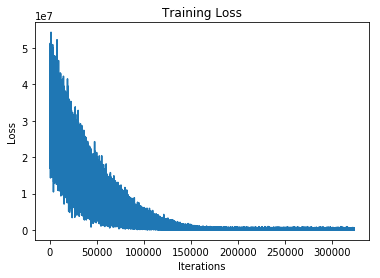

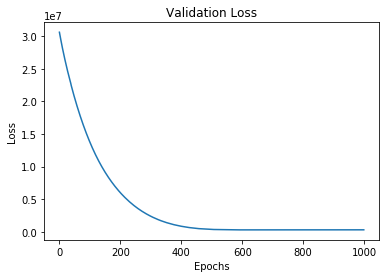

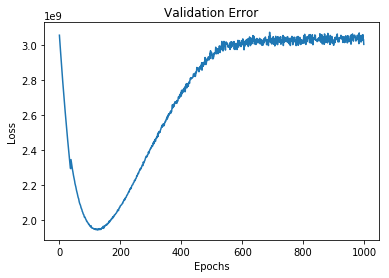

0.9797640561619182

In [18]:
def test(net):
    idxList = range(len(testFeat))
    Rscore = 0.0
    numB = 0
    while(len(idxList)>0):
        batchIdxs = []
        for idxz in range(BATCH_SIZE):
            if len(idxList) == 0:
                break
            batchIdxs.append(idxList.pop())
        
        batch_data = testFeat[batchIdxs]
        batch_F = batch_data[:,1:]
        batch_L = batch_data[:,0]
    
        inData = torch.from_numpy(batch_F)
        inData = inData.float()
        inData = Variable(inData.cuda())
        
        label = torch.from_numpy(batch_L)
        label = label.float()
        label = Variable(label.cuda(),requires_grad=False)
        
        # forward pass
        outData = net(inData)
        
        outData = outData.cpu().data.numpy()
        label = label.cpu().data.numpy()
        
        Rscore += r2_score(outData,label)
        numB += 1
    return Rscore/numB

print 'Test Rscore: %.4f' % test(net)

plt.plot(trainLoss)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(valLoss)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(valError)
plt.title('Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [19]:
print AVERAGES

[0.7999539611914426, 61.754072426152334, 57.45404461747613, 5.735180756395909, 5.738573105920151, 3.540883079965383]
